_The main focus of this assignment is Building Recommendation Systems from theoretical as well as practical perspective_

## Problem 1: Implementing Recommendation Systems

The goal of this task is to predict the recommendation score for products given user reviews. The data consists of products as columns and users as rows. The data is given as follows where P refers to the product and U refers to the user. An entry in each cell refers to the users review score or recommendation for that product.

|   | P1 | P2 | P3 | P4 | P5 | P6 | P7 | P8 | P9 | P10 | 
|----|----|----|----|----|----|----|----|----|----|-----| 
| U1 | 3  | 7  | 4  | 9  | 9  | 7  | 6  | 7  | 8  | 8   | 
| U2 | 7  | 5  | 5  | 3  | 8  | 8  | 7  | 4  | 9  | 5   | 
| U3 | 7  | 5  | 5  | 0  | 8  | 4  | 8  | 6  | 7  | 9   | 
| U4 | 5  | 6  | 8  | 5  | 9  | 8  | 5  | 7  | 10 | 7   | 
| U5 | 5  | 8  | 8  | 8  | 10 | 9  | 7  | 4  | 9  | 8   | 
| U6 | 7  | 7  | 8  | 4  | 7  | 8  | 6  | 7  | 7  | 8   | 


Consider the following test set of users. The missing values are the products that the corresponding users have not bought. Given this dataset, determine which products U7, U8 and U9 should buy. Show the recommendation scores for the top 3 products.

|   | P1  | P2  | P3  | P4  | P5  | P6  | P7  | P8  | P9  | P10 | 
|----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----| 
| U7 |  ?  | 6   | 9   |   ? |   ? | 6   |   ? | 9   |   ? |   ? | 
| U8 | 7   |   ? | 9   |   ? | 4   |  ?  | 9   |  ?  | 7   |   ? | 
| U9 |   ? | 6   |   ? | 9   |   ? | 7   |   ? | 8   |   ? | 4   | 


In [76]:
# Load the Relevant libraries
import sklearn as sk
import pandas as pd
import numpy as np

train = pd.read_csv("ratingsDataTrain.csv",index_col=[0])
test = pd.read_csv("ratingsDataTest.csv",index_col=[0])
test = test.rename(index=dict(zip(['U1','U2','U3'],['U7','U8','U9'])))
og_test = test.copy()

In [77]:
nearest_neighbor = {}
# for each user in our test set, find their nearest neighbor
for u in test.index:
    # append the user to the training set
    j = train.append(test.loc[u])
    # find the correlation matrix
    corr_mat = j.T.corr()
    # eliminate the diagonal perfect correlation
    corr_mat = corr_mat.replace(1.0,0.0)
    # find the nearest neighbor for everyone
    NNs = corr_mat.idxmax(axis=1)
    # extract out just the user from the test set
    nearest_neighbor.update({u:NNs[u]})

In [78]:
test_users = ['U7','U8','U9']

# for each of our users in the test set, fill their gaps with the review from their most comparable user
# replace their missing data in the test set to fill out the test set
# returns a df with no missing data
for u in test_users:
    best_comp = nearest_neighbor.get(u)
    test.loc[u] = test.loc[u].combine_first(train.loc[best_comp])

In [79]:
test

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
U7,7.0,6.0,9.0,0.0,8.0,6.0,8.0,9.0,7.0,9.0
U8,7.0,7.0,9.0,4.0,4.0,8.0,9.0,7.0,7.0,8.0
U9,3.0,6.0,4.0,9.0,9.0,7.0,6.0,8.0,8.0,4.0


In [80]:
og_test

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
U7,NaN,6.0,9.0,NaN,NaN,6.0,NaN,9.0,NaN,NaN
U8,7.0,NaN,9.0,NaN,4.0,NaN,9.0,NaN,7.0,NaN
U9,NaN,6.0,NaN,9.0,NaN,7.0,NaN,8.0,NaN,4.0


#### The highest rated products that our test users have not bought yet:

|  User | Suggested Purchase  | Anticipated Review Score
|----|:---:|:-:|
| U7 |  P10  | 9 |
| U8 | P6 or P10|8|
| U9 | P5 | 9 |

## Problem 2: Social Recommendation Systems

Using the FilmTrust dataset which has historical likes information and social network connection create recommendation systems, pick any three pairs of randomly selected users and 2 randomly selected movies and make recommendations with and without the social network information.


In [81]:
# https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/

In [82]:
# Load the Relevant libraries
import sklearn as sk

# URL for the Social Network Data (UW Repository)
url = "FilmTrustSocialNetwork.txt"
colnames= ['uid', 'item', 'rating']
sn = pd.read_table(url,sep=' ',header=0,names=colnames,dtype={'uid':str,'item':str})

# URL for the Ratings Data (UW Repository)
url = "FilmTrustRatings.txt"
colnames = ['trustor','trustee','val']
rats = pd.read_table(url,sep=' ',header=0,names=colnames,dtype={'trustor':str,'trustee':str})

In [83]:
print('Number of unique users: ',sn.uid.nunique())
print('Number of unique items: ',sn.item.nunique())

Number of unique users:  609
Number of unique items:  731


In [84]:
# how many people can one person trust (whoa - deep)
# looks like one person can have multiple connections to others
rats.groupby('trustor')['trustee'].nunique().describe()

count    1508.000000
mean       23.536472
std        23.699414
min         1.000000
25%         6.000000
50%        16.000000
75%        39.000000
max       244.000000
Name: trustee, dtype: float64

In [85]:
# How many movies has each user rated
sn.groupby('uid')['item'].nunique().describe()

count    609.000000
mean       3.041051
std        4.385978
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       59.000000
Name: item, dtype: float64

In [86]:
# Let's gather some info on the ratings themselves
ratings = pd.DataFrame(sn.groupby('item')['rating'].mean())
ratings['count'] = sn.groupby('item')['item'].count()
ratings = ratings.reset_index()
ratings.columns = ['item','mean_rating','ratings_count']

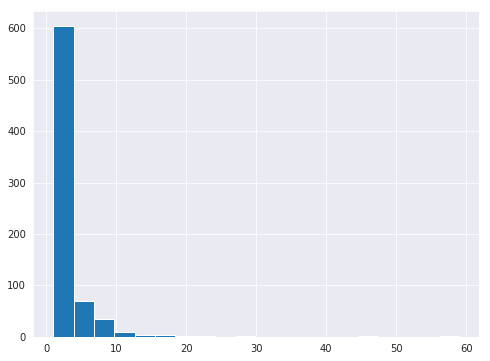

In [87]:
# how many ratings do we have for each item?

import matplotlib.pyplot as plt  
import seaborn as sns  
sns.set_style('dark')  
%matplotlib inline

plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
ratings['ratings_count'].hist(bins=20) 

### Build user-user collaborative filter

In [88]:
# are there any users that only have one rating?
# Users with only one rating won't be very helpful for user-user CF
# Filter out these people
user_rating_count = sn.groupby('uid')['item'].nunique().reset_index()
n = len(user_rating_count)
user_rating_count = user_rating_count[user_rating_count['item']>1]
n1 = len(user_rating_count)
print('Removed %d users with insufficient reviews.' % (n-n1))
sn = sn[sn['uid'].isin(user_rating_count['uid'])]

Removed 290 users with insufficient reviews.


In [146]:
# define mean review for every user
# first, rotate the data so every row is one user
base = sn.pivot(index='uid',columns='item',values='rating')
base['mean_review'] = base.mean(axis=0)

In [152]:
# WHY DOESN'T THIS WORK?

In [147]:
base.head()

item,100,1000,1003,1013,1014,1015,1016,1018,1019,1021,...,965,969,975,977,979,986,989,99,999,mean_review
uid,,,,,,,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [154]:
base.loc['1002'].dropna()

item
298    1.0
683    1.0
80     1.0
898    1.0
Name: 1002, dtype: float64

In [189]:
# let's see what happens if we only include items with at least three reviews
print('Size of complete data: ',ratings.shape)
print('Size of data with only three or more reviews: ',ratings[ratings['ratings_count']>=3].shape)

Size of complete data:  (731, 3)
Size of data with only three or more reviews:  (175, 3)


In [190]:
# parse the data down to just items with at least three reviews
items_to_keep = ratings[ratings['ratings_count']>=3]['item']

sn = sn[sn['item'].isin(items_to_keep)]

In [191]:
# in order to find correlation with other items, users must have some overlap

0

In [192]:
# restructure data so movies are along the x and users on the y
# will end up with a record for every item and user combo
base = sn.pivot_table(index='uid',columns='item',values='rating')

In [193]:
base.head()

item,1016,1018,1019,1033,1034,1039,1041,1056,1062,1065,...,931,938,94,95,96,965,969,986,989,999
uid,,,,,,,,,,,,,,,,,,,,,
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
item_ratings = base['1016']
comps = base.corrwith(item_ratings)

comps_to_six = pd.DataFrame(comps, columns=['Correlation'])
comps_to_six.dropna(inplace=True)
comps_to_six.head()

# movies_like_forest_gump = user_movie_rating.corrwith(forrest_gump_ratings)

# corr_forrest_gump = pd.DataFrame(movies_like_forest_gump, columns=['Correlation'])  
# corr_forrest_gump.dropna(inplace=True)  
# corr_forrest_gump.head() 

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
item,


In [195]:
sn[sn['item']=='1016']

,uid,item,rating
1106,892,1016,1
1552,1616,1016,1
1765,1424,1016,1


In [200]:
sn[sn['uid']=='1424']['item']

1765    1016
1766    1242
1767    1272
Name: item, dtype: object

In [201]:
sn[sn['uid']=='892']['item']

1095     509
1096     969
1097    1532
1098     188
1099    1147
1100    1159
1102    1398
1103     313
1104     436
1106    1016
1107     965
1108    1481
1109      29
Name: item, dtype: object

In [144]:
# if you rated item 'six', did you rate anything else?
rated_six = sn[sn['item']=='6']['uid']
sn[sn['uid'].isin(rated_six)]['item'].nunique()

41

In [145]:
item_ratings.isnull().sum()

604

In [146]:
print(comps.shape)
comps.isnull().sum()

(731,)


731

In [15]:
userID = 2

def uid_picks(uid,ratings):
    ratings = ratings[ratings['uid']==uid]
    return uid_ratings

def find_comps(uid_ratings,ratings):
    ratings = ratings[ratings['item']==item]
    return item_ratings

,uid,item,rating
0,2,104,1


In [17]:
base.corrwith(base['2'])

/usr/local/lib/python3.5/dist-packages/pandas/core/ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison